In [1]:
# made 4/16 after make_stations confusion over which are the right time points or not - NO FILTER CLASSIFIER NOW

In [2]:
import numpy as np
import nibabel
import nilearn
from nilearn.image import resample_to_img
import matplotlib.pyplot as plt
from nilearn import plotting
from nilearn.plotting import show
from nilearn.plotting import plot_roi
from nilearn import image
from nilearn.masking import apply_mask
# get_ipython().magic('matplotlib inline')
import scipy
import matplotlib
import matplotlib.pyplot as plt
from nilearn import image
from nilearn.input_data import NiftiMasker
#from nilearn import plotting
import nibabel
from nilearn.masking import apply_mask
from nilearn.image import load_img
from nilearn.image import new_img_like
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets, svm, metrics
from sklearn.linear_model import Ridge
from sklearn.svm import SVC, LinearSVC
from sklearn.cross_validation import KFold
from sklearn.cross_validation import LeaveOneLabelOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.feature_selection import SelectFwe
from scipy import signal
from scipy.fftpack import fft, fftshift
from scipy import interp

params = {'legend.fontsize': 'large',
          'figure.figsize': (5, 3),
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}
font = {'weight': 'bold',
        'size': 22}
plt.rc('font', **font)
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile, f_classif, GenericUnivariateSelect, SelectKBest, chi2
from sklearn.feature_selection import RFE
import os
import seaborn as sns
import pandas as pd
import csv
from scipy import stats
import brainiak
import brainiak.funcalign.srm
import glob

/jukebox/pkgs/PYGER/beta/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/jukebox/pkgs/PYGER/beta/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
projectDir='/jukebox/norman/amennen/prettymouth_fmriprep2/'
DMNmask='/jukebox/norman/amennen/MNI_things/Yeo_JNeurophysiol11_MNI152/Yeo_Network7mask_reoriented_resampledBOLD.nii.gz'
fmriprep_dir=projectDir + '/derivatives/fmriprep'

# load subject numbers
subInd = 0
nsub=38
allnames = []
allgroups = []
groupInfo={}
# skip subjects 039 and 116
with open(projectDir + 'participants.tsv') as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    for row in csvReader:
        if 'sub' in row[0]:
            # now skip the subjects we don't want to analyze
            allInfo = row[0].split('\t')
            subjName=allInfo[0]
            if subjName != 'sub-039' and subjName != 'sub-116':
                if allInfo[3] == 'paranoia':
                    group = 0
                elif allInfo[3] == 'affair':
                    group = 1
                allnames.append(subjName)
                allgroups.append(group)
                subInd+=1

paranoidSubj = allnames[0:19]
cheatingSubj = allnames[19:]
paranoidLabel = allgroups[0:19]
cheatingLabel = allgroups[19:]
nfolds=19
print(allnames)
segment_score_vector = np.load('segment_score_vector.npy')
beliefs_vector = np.load('beliefs_vector.npy')
emotions_vector = np.load('emotions_vector.npy')
intentions_vector = np.load('intentions_vector.npy')

['sub-088', 'sub-089', 'sub-090', 'sub-091', 'sub-092', 'sub-093', 'sub-094', 'sub-095', 'sub-096', 'sub-097', 'sub-098', 'sub-099', 'sub-100', 'sub-101', 'sub-102', 'sub-103', 'sub-104', 'sub-105', 'sub-106', 'sub-107', 'sub-108', 'sub-109', 'sub-110', 'sub-111', 'sub-068', 'sub-081', 'sub-112', 'sub-053', 'sub-113', 'sub-031', 'sub-114', 'sub-115', 'sub-117', 'sub-118', 'sub-119', 'sub-120', 'sub-121', 'sub-122']


In [4]:
# load the winning classifier combination
# load the specified winning combination
classifierType = 1
ROI = 1
removeAvg = 1
filterType = 0
k1 = 0
k2 = 25
boostrapped = 1 # whether or not to randomly sample training data w/ replacement
lowhigh = 0

if not boostrapped:
    filename_data = glob.glob('new_bothphases/ARRAYDATA' + '_ROI_' + str(ROI) + '_AVGREMOVE_' + str(removeAvg) +  '_classifierType_' + str(classifierType) + '_filter_' + str(filterType) + '_lowhigh_' + str(lowhigh) + '_k1_' + str(k1) + '_k2_' + str(k2) + '_perm_*.npy')
else:
    filename_data = glob.glob('new_bothphases/ARRAYDATA_BS_' + '_ROI_' + str(ROI) + '_AVGREMOVE_' + str(removeAvg) +  '_classifierType_' + str(classifierType) + '_filter_' + str(filterType) + '_lowhigh_' + str(lowhigh) + '_k1_' + str(k1) + '_k2_' + str(k2) + '_perm_*.npy')
#print(filename_data)
accuracy = np.load(filename_data[0]).T # this is 450 TRs x 1000 examples
nTR = np.shape(accuracy)[1]
np.mean(accuracy)

0.5555044444444445

In [5]:
nTR

450

(447,)
(1000, 447)


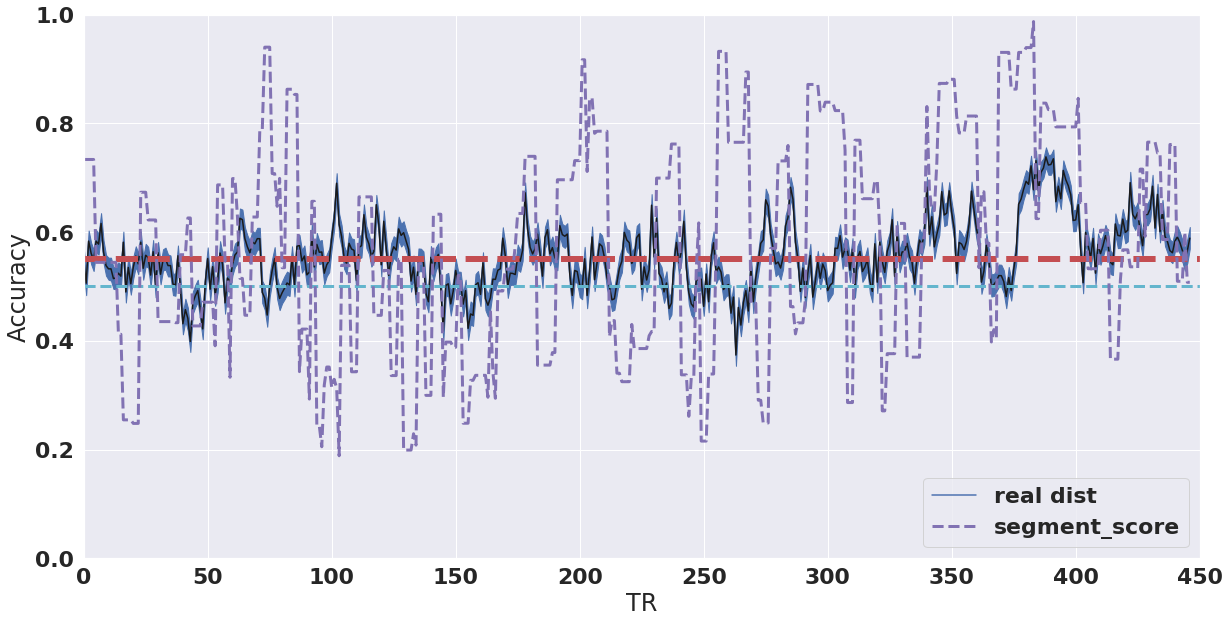

REAL correlation is 0.2106
REAL p value is 0.0000


Text(0,0.5,'Zscored segment difference')

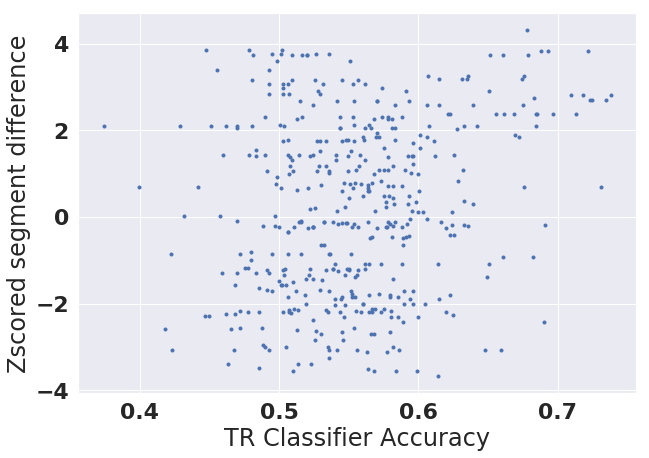

In [9]:
x = np.arange(nTR-3)
y = accuracy[:,3:]
mean_acc = np.mean(y,axis=0)

print(np.shape(x))
print(np.shape(y))
# make into dataframe: TR, accuracy
n_iter=1000
TR_vec = np.tile(x,n_iter)
data = y.flatten()

iter_number = np.repeat(np.arange(n_iter),nTR-3)
matrix = np.concatenate((TR_vec[:,np.newaxis],data[:,np.newaxis],iter_number[:,np.newaxis]),axis=1)
df = pd.DataFrame(data=matrix, columns = ['TR', 'accuracy','iter'])

sns.set(style="white")
sns.set(font_scale=2)
err_band = {}
err_band['alpha'] = 1

plt.figure(figsize=(20,10))
sns.lineplot(x="TR",y="accuracy",color='b',data=df,ci=95,err_kws=err_band,label='real dist')

plt.plot(x,np.mean(y,axis=0), color='k')
#plt.plot(x,np.mean(y,axis=0), color='k', label='accuracy')
plt.plot([0 ,500], [.55, .55], 'r--', lw=6)
plt.plot([0 ,500], [.5, .5], 'c--', lw=3)
plt.ylim([0,1])
plt.xlim([0,nTR])

plt.plot(segment_score_vector[0:-3]/10 + np.mean(y), '--', color='m', label='segment_score',linewidth=3)
plt.plot()
plt.legend(loc=4)
plt.ylabel('Accuracy')
plt.show()
[corr,p] = scipy.stats.pearsonr(mean_acc,segment_score_vector[0:-3])
print('REAL correlation is %4.4f' % corr)
print('REAL p value is %4.4f' % p)

plt.figure(figsize=(10,7))
plt.plot(mean_acc,segment_score_vector[0:-3], '.')
plt.xlabel('TR Classifier Accuracy')
plt.ylabel('Zscored segment difference')

In [1]:
np.shape(accuracy)

NameError: name 'np' is not defined

[  5   6  28  29  64  65  71  72  73  74 114 115 116 117 118 119 145 146
 180 181 182 183 184 185 195 196 197 198 211 212 213 280 281 285 286 287
 306 307 308 309 310 315 316 333 334 341 342 343 344 345 346 347 348 349
 350 351 352 353 354 356 357 358 359 360 361 362 363 379 380 381 382 383
 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
 402 403 404 405 413 414 415 416 422 423 424 429 430 431 432 433 434 435
 436 437 438 439 440 441 442 443]
[  5   6   8   9  10  11  19  24  26  28  29  31  33  36  41  53  58  64
  65  66  67  68  69  70  71  72  73  74  80  87  89  90  92  95  97  98
  99 103 104 105 106 107 108 110 111 112 114 115 116 117 118 119 120 121
 122 124 125 127 128 129 130 131 132 133 134 143 145 146 172 173 178 180
 181 182 183 184 185 186 187 189 190 191 192 193 195 196 197 198 205 208
 211 212 213 221 222 223 225 226 227 232 233 234 242 244 245 256 257 276
 277 278 279 280 281 285 286 287 288 289 290 291 296 306 307 308 309 310
 311 313 315 316 

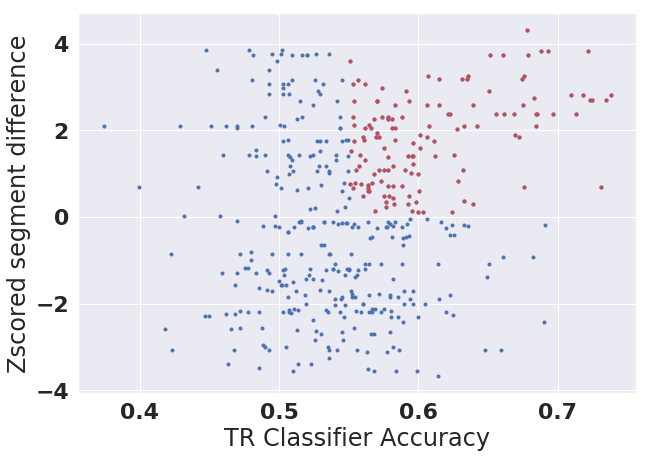

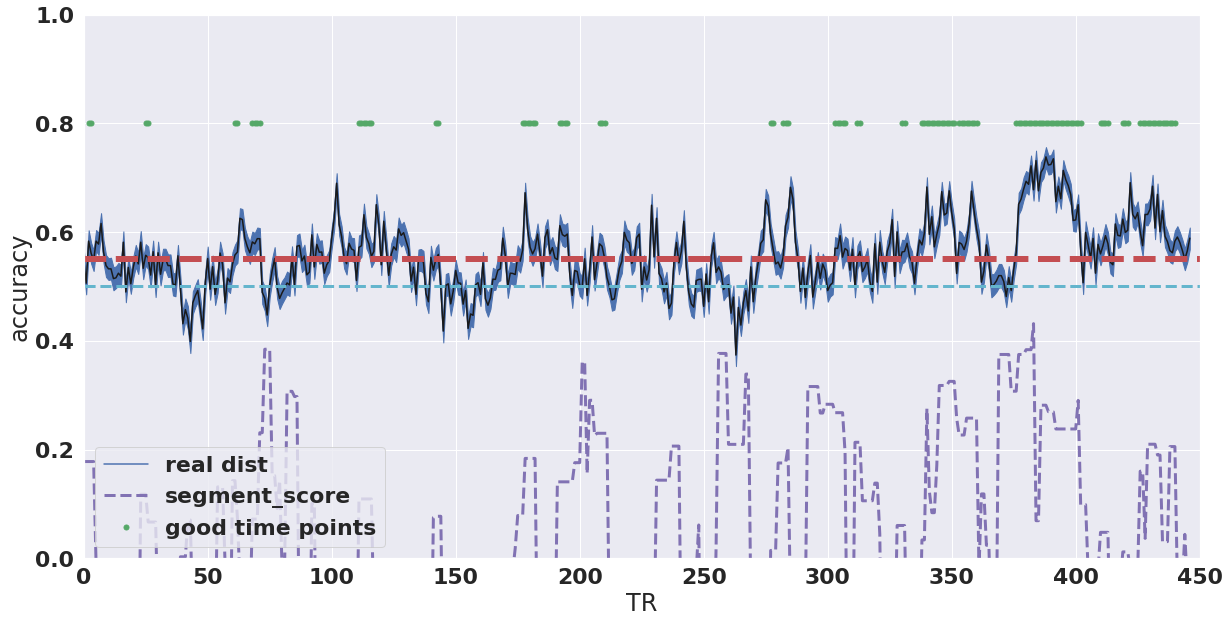

In [30]:
seg_shifted = segment_score_vector[0:-3]
TR_vector = np.arange(len(seg_shifted))
large_diff = seg_shifted > 0
large_acc = mean_acc > 0.55
upper_right = np.intersect1d(TR_vector[large_diff],TR_vector[large_acc])

plt.figure(figsize=(10,7))
plt.plot(mean_acc,segment_score_vector[0:-3], '.')
plt.plot(mean_acc[upper_right],seg_shifted[upper_right], 'r.')
plt.xlabel('TR Classifier Accuracy')
plt.ylabel('Zscored segment difference')

#print(upper_right)
# adding a couple points with high accuracy
#points_to_add = np.arange(144,153)
#print(points_to_add)
#new_upper_right = np.sort(np.concatenate((upper_right,points_to_add),axis=0))
#differences = np.diff(new_upper_right)

# 4/16: going back to upper_right
new_upper_right = upper_right
differences = np.diff(new_upper_right)
good_diff = np.argwhere(differences==1)
good_time_points = []
for i in np.arange(len(good_diff)):
    this_diff = good_diff[i][0]
    good_time_points.append(new_upper_right[this_diff])
    good_time_points.append(new_upper_right[this_diff+1])
final_good = np.unique(good_time_points)

vector_TR = -1*np.ones((len(mean_acc),))
vector_TR[final_good] = 0.8
plt.figure(figsize=(20,10))
sns.lineplot(x="TR",y="accuracy",color='b',data=df,ci=95,err_kws=err_band,label='real dist')
plt.plot(segment_score_vector[0:-3]/10 + 0, '--', color='m', label='segment_score',linewidth=3)
plt.plot(x,np.mean(y,axis=0), color='k')
plt.plot(np.arange(len(mean_acc)),vector_TR,'g.', label='good time points', markersize=10)
plt.legend(loc=3)

#plt.plot(x,np.mean(y,axis=0), color='k', label='accuracy')
plt.plot([0 ,500], [.55, .55], 'r--', lw=6)
plt.plot([0 ,500], [.5, .5], 'c--', lw=3)
plt.ylim([0,1])
plt.xlim([0,nTR])

#print(final_good)
print(final_good+3)
shifted_back = final_good+3

print(TR_vector[large_acc]+3)

In [ ]:
# points with threshold > 0.55
[  5   6  28  29  64  65  71  72  73  74 114 115 116 117 118 119 145 146
 180 181 182 183 184 185 195 196 197 198 211 212 213 280 281 285 286 287
 306 307 308 309 310 315 316 333 334 341 342 343 344 345 346 347 348 349
 350 351 352 353 354 356 357 358 359 360 361 362 363 379 380 381 382 383
 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
 402 403 404 405 413 414 415 416 422 423 424 429 430 431 432 433 434 435
 436 437 438 439 440 441 442 443]

# [points with threshold > 0.6]
[181 182 286 287 348 349 350 351 352 353 354 360 361 362 363 380 381 382
 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400
 401 402 403 404 431 432 433 434 435 436 437 438]



In [28]:
# going to buid dictionary--adding a couple more where it makes sense adn the score diff was higher right before and will retest again
# FROM UPPER RIGHT STATIONS
station_dict = {}
station_dict[0] = [5,6 ]
station_dict[1] = [28,29]
station_dict[2] = [64 , 65]
station_dict[3] = [71 , 72 , 73 , 74]
# try combining
station_dict[25] = [64,65,66,67,68,69,70,71,72,73,74]
station_dict[4] = [114 ,115, 116 ,117, 118, 119]
station_dict[5] = [145 ,146]
station_dict[6] = [180, 181, 182, 183, 184 ,185]
station_dict[7] = [195, 196, 197, 198]
station_dict[8] = [211, 212, 213]
station_dict[9] = [280, 281]
station_dict[10] = [285, 286 ,287]
station_dict[26] = [280,281,282,283,284,285]
station_dict[11] = [306, 307, 308 ,309, 310]
station_dict[12] = [ 315, 316]
station_dict[13] = [ 333, 334]
station_dict[14] = [341, 342, 343, 344, 345 ,346, 347 ,348, 349 , 350 ,351, 352, 353, 354, 356, 357, 358, 359 ,360 ,361, 362, 363] # added to see if this is okay
station_dict[15] = [379 ,380, 381, 382 ,383 ,384, 385, 386 ,387, 388, 389, 390 ,391 ,392 ,393 ,394, 395, 396, 397 ,398 ,399, 400, 401, 402, 403, 404, 405]
station_dict[16] = [413 ,414 ,415, 416]
station_dict[17] = [422, 423, 424]
station_dict[18] = [429 ,430, 431 ,432, 433, 434, 435,  436, 437 ,438 ,439, 440, 441 ,442, 443]
station_dict[19] = [181 ,182]
station_dict[20] = [286 ,287]
station_dict[21] = [348, 349, 350 ,351, 352 ,353 ,354]
station_dict[22] = [360 ,361 ,362 ,363]
station_dict[23] = [380 ,381 ,382, 383, 384 ,385 ,386, 387 ,388, 389, 390, 391 ,392, 393 ,394, 395, 396 ,397 ,398, 399, 400 ,401, 402 ,403 ,404]
station_dict[24] = [431 ,432, 433, 434 ,435, 436, 437 ,438]
np.save('stations_upper_right_nofilter.npy', station_dict)

In [29]:
# accuracy only > 0.55
[  5   6   8   9  10  11  19  24  26  28  29  31  33  36  41  53  58  64
  65  66  67  68  69  70  71  72  73  74  80  87  89  90  92  95  97  98
  99 103 104 105 106 107 108 110 111 112 114 115 116 117 118 119 120 121
 122 124 125 127 128 129 130 131 132 133 134 143 145 146 172 173 178 180
 181 182 183 184 185 186 187 189 190 191 192 193 195 196 197 198 205 208
 211 212 213 221 222 223 225 226 227 232 233 234 242 244 245 256 257 276
 277 278 279 280 281 285 286 287 288 289 290 291 296 306 307 308 309 310
 311 313 315 316 322 324 327 328 329 331 333 334 335 336 339 340 341 342
 343 344 345 346 347 348 349 350 351 352 353 354 356 357 358 359 360 361
 362 363 364 367 379 380 381 382 383 384 385 386 387 388 389 390 391 392
 393 394 395 396 397 398 399 400 401 402 403 404 405 407 408 409 410 412
 413 414 415 416 419 420 421 422 423 424 425 426 427 428 429 430 431 432
 433 434 435 436 437 438 439 440 441 442 443 444 445 446 448 449]

In [34]:
# here I'm making stations to test everything with > 0.55 for mega test, not upper right
station_dict = {}
station_dict[0] = [8 ,  9 , 10,  11 ]
station_dict[1] = [ 31 ,32, 33,34,35 , 36]
station_dict[2] = [64,65 , 66 , 67,  68 , 69 , 70 , 71,  72 , 73 , 74]
station_dict[3] = [71 , 72 , 73 , 74]
# try combining
station_dict[4] = [97 , 98, 99]
station_dict[5] = [103, 104, 105, 106, 107, 108]
station_dict[6] = [110 ,111 ,112]
station_dict[7] = [114, 115, 116,117, 118, 119, 120, 121 ,122]
station_dict[8] = [124,125]
station_dict[9] = [127 ,128 ,129 ,130, 131 ,132 ,133 ,134]
station_dict[10] = [145 ,146]
station_dict[25] = [172, 173]
station_dict[11] = [180,181, 182, 183 ,184, 185, 186 ,187]
station_dict[12] = [189 ,190, 191, 192, 193, 195, 196, 197, 198]
station_dict[13] = [ 211 ,212, 213]
station_dict[14] = [ 221, 222 ,223] # added to see if this is okay
station_dict[15] = [225 ,226 ,227]
station_dict[16] = [232, 233 ,234]
station_dict[17] = [244, 245]
station_dict[18] = [256 ,257]
station_dict[19] = [181 ,182]
station_dict[20] = [286 ,287]
station_dict[21] = [276, 277 ,278 ,279, 280, 281]
station_dict[22] = [ 285 ,286 ,287,288, 289, 290, 291]
station_dict[23] = [306, 307, 308 ,309, 310, 311]
station_dict[24] = [315 ,316]
station_dict[26] = [327 ,328 ,329]
station_dict[27] = [333, 334, 335 ,336]
station_dict[28] = [339 ,340 ,341, 342 ,343 ,344 ,345 ,346, 347, 348 ,349 ,350 ,351, 352, 353, 354]
station_dict[29] = [356, 357, 358, 359 ,360 ,361, 362 ,363, 364]
station_dict[30] = [379, 380, 381,382, 383, 384 ,385 ,386, 387, 388, 389 ,390 ,391, 392 ,393 ,394, 395, 396 ,397, 398, 399 ,400 ,401, 402, 403, 404, 405]
station_dict[31] = [407, 408, 409 ,410]
station_dict[32] = [412, 413,414 ,415, 416]
station_dict[33] = [419 ,420 ,421, 422 ,423, 424, 425, 426, 427, 428, 429, 430 ,431 ,432, 433 ,434 ,435 ,436, 437, 438 ,439, 440, 441, 442, 443, 444, 445, 446]
station_dict[34] = [448, 449]
np.save('mega_testing_stations_nofilter.npy', station_dict)